# Nearest Neighbor Classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## 3.1 Exploring the Data

In [2]:
# load dataset from from sklearn
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.keys())

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [3]:
print(type(digits))
print(digits.data.shape)
print(digits.data.dtype)
print(digits.target.shape)

<class 'sklearn.utils.Bunch'>
(1797, 64)
float64
(1797,)


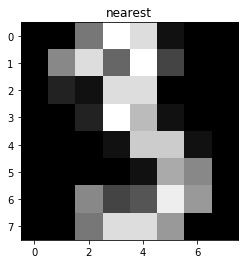

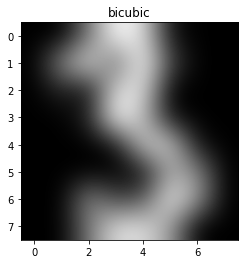

In [4]:
# visualize one image of a 3
def show_a_3(digits):
    n = digits.target.shape[0]
    for i in range(n):
        # find an image of number 3
        if digits.target[i] == 3:
            plt.figure()
            plt.gray()
            plt.imshow(digits.images[i], interpolation="nearest")
            plt.title("nearest")
            plt.show()
            plt.imshow(digits.images[i], interpolation="bicubic")
            plt.title("bicubic")
            plt.show()
            return

show_a_3(digits)

## 3.2 Distance function  computation using loops

In [5]:
def dist_loop(training, test):
    """
    calculate the distance between instances in test set and training set
    Args:
        training: N*D matrix, and D is the number of pixels in one image
        test: M*D matrix
    Returns:
        distances: N*M matrix, and distances[i][j] is the distance between training[i] and test[j]
    """
    N = training.shape[0]
    M = test.shape[0]
    distances = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            vec_i = training[i]
            vec_j = test[j]
            distances[i][j] = np.linalg.norm(np.subtract(vec_i, vec_j))
    return distances
    

## 3.3 Distance function computation using vectorization

In [6]:
def dist_vec(training, test):
    """
    calculate the distance matrix using vectorization method
    """
    training_square = np.sum(training*training, axis=1, keepdims=True)
    test_square = np.sum(test*test, axis=1, keepdims=True).T
    distances = np.dot(training, test.T)
    distances *= -2
    distances += training_square
    distances += test_square
    np.maximum(distances, 0, distances)
    np.sqrt(distances, distances)
    return distances

## 3.4 Implement K-Nearest Neighbor classifier

In [7]:
# split data into training set and test set
from sklearn import model_selection
X_all = digits.data
Y_all = digits.target
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_all, Y_all, test_size=0.2, random_state=0)

    error rate
K             
1     0.011111
3     0.016667
5     0.025000
9     0.025000
11    0.027778
33    0.041667


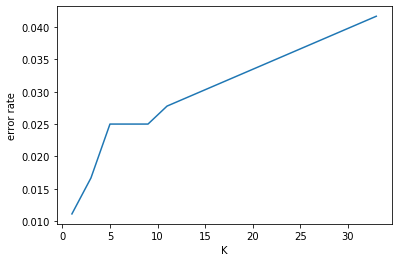

In [8]:
def init_dict():
    """
    initialize a dictionary whose key is target 0~9, 
    the value is the target frequency of the nearest K neighbors
    """
    dct = dict()
    for i in range(10):
        dct[i] = 0
    return dct

def pick_highest_freq(dct):
    index = 0
    maximum = 0
    for i in range(10):
        if dct[i]>maximum:
            index = i
            maximum = dct[i]
    return index


def arg_topK(distances, K, axis=0):
    """
    Args:
        distances: N*M
        K
        axis
    Returns:
        topK: K*M matrix, and topK[:, j]: the top K nearest neighbor of test[j]
    """
    full_sort = np.argsort(distances, axis)
    return full_sort.take(np.arange(K), axis)

def KNN_classifier(X_train, X_test, Y_train, Y_test, K):
    # compute the distance matrix
    distances = dist_vec(X_train, X_test)  # distances[i][j]: distance of test[j] to train[i]
    # select top K nearest neighbors of every test image in the training set
    topK = arg_topK(distances, K, axis=0)  # topK: matrix K*M
    Y_pred = np.zeros(Y_test.shape)
    for i in range(Y_test.shape[0]):
        nearest_neighbors = topK[:, i] # nearest neighbors of test[i]
        # pick the most frequently appeared number as prediction
        dct = init_dict()
        for index in nearest_neighbors:
            y = Y_train[index]
            dct[y] = dct[y] + 1
        Y_pred[i] = pick_highest_freq(dct)
    return Y_pred


def cal_err(Y_test, Y_pred):
    return np.sum(np.subtract(Y_test, Y_pred)!=0)/Y_pred.size

def testKNN(Ks):
    errs = []
    for k in Ks:
        Y_pred = KNN_classifier(X_train, X_test, Y_train, Y_test, k)
        err = cal_err(Y_test, Y_pred)
        errs.append(err)
    knn_stats = {
        "K": Ks,
        "error rate": errs}
    df = pd.DataFrame(knn_stats)
    df.set_index("K", inplace=True)
    print(df)
    fig, ax = plt.subplots()
    ax.plot(Ks, errs)
    ax.set_xlabel("K")
    ax.set_ylabel("error rate")

testKNN([1,3,5,9,11,33])

## 4 Cross-validation

In [9]:
def split_folds(X_all, Y_all, L):
    """
    split X and Y into L parts
    """
    X_folds = []
    Y_folds = []
    N = X_all.shape[0]
    rand_permt = np.random.permutation(np.arange(N))
    rand_permt_splits = np.array_split(rand_permt, L)  # split the random permutation into L parts
    for i in range(L):
        X_folds.append(X_all.take(rand_permt_splits[i], 0))
        Y_folds.append(Y_all.take(rand_permt_splits[i], 0))
    return X_folds, Y_folds

def get_train_test(folds, i):
    """
    select the folds[i] as the test set
    and merge the rest into the training set
    """
    test = folds[i]
    if len(folds[0].shape) == 1:  # if the dimention == 1, use hstack
        train = np.hstack(tuple((folds[j] for j in range(len(folds)) if i!=j)))
    else:
        train = np.vstack(tuple((folds[j] for j in range(len(folds)) if i!=j)))
    return train, test
        
def cross_validation(X_folds, Y_folds, K):
    errs = []
    L = len(X_folds)
    for i in range(L):
        # in every iteration, select i th part of data as the test set
        # and merge the rest as the training data
        # calculate the error rate of KNN
        X_train, X_test = get_train_test(X_folds, i)
        Y_train, Y_test = get_train_test(Y_folds, i)
        Y_pred = KNN_classifier(X_train, X_test, Y_train, Y_test, K)
        err = cal_err(Y_pred, Y_test)
        errs.append(err)
    return errs
    
X_all = digits.data
Y_all = digits.target
X_folds, Y_folds = split_folds(X_all, Y_all, 15)

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
# use sklearn library for evaluation
def cross_validation_sklearn(X_folds, Y_folds, K):
    errs = []
    L = len(X_folds)
    for i in range(L):
        knn = KNeighborsClassifier(n_neighbors=K)
        X_train, X_test = get_train_test(X_folds, i)
        Y_train, Y_test = get_train_test(Y_folds, i)
        knn.fit(X_train, Y_train)
        Y_pred = knn.predict(X_test)
        err = cal_err(Y_pred, Y_test)
        errs.append(err)
    return errs

In [12]:
def alg_compare(Ls, Ks, X_all, Y_all):
    for l in Ls:
        means_my = []
        means_sk = []
        stds_my = []
        stds_sk = []
        for k in Ks:
            X_folds, Y_folds = split_folds(X_all, Y_all, l)
            errs_my = cross_validation(X_folds, Y_folds, k)
            errs_sk = cross_validation_sklearn(X_folds, Y_folds, k)
            means_my.append(np.mean(errs_my))
            means_sk.append(np.mean(errs_sk))
            stds_my.append(np.std(errs_my))
            stds_sk.append(np.std(errs_sk))
        alg_stats = {
            "K":Ks,
            "my_mean":means_my,
            "sklearn_mean":means_sk,
            "my_stds":stds_my,
            "sklearn_stds":stds_sk
        }
        df = pd.DataFrame(alg_stats)
        df.set_index("K", inplace=True)
        print("L=",l)
        print(df)

alg_compare([2,5,10],[1,3,5,9,15], X_all, Y_all)

L= 2
     my_mean  sklearn_mean   my_stds  sklearn_stds
K                                                 
1   0.014469      0.014469  0.001121      0.001121
3   0.017808      0.017808  0.001123      0.001123
5   0.020032      0.020032  0.003328      0.003328
9   0.025598      0.025041  0.000014      0.000543
15  0.036174      0.036174  0.005028      0.005028
L= 5
     my_mean  sklearn_mean   my_stds  sklearn_stds
K                                                 
1   0.012795      0.012795  0.007157      0.007157
3   0.013909      0.013909  0.004295      0.004295
5   0.013358      0.013358  0.003701      0.003701
9   0.018372      0.018372  0.006509      0.006509
15  0.025045      0.025045  0.004995      0.004995
L= 10
     my_mean  sklearn_mean   my_stds  sklearn_stds
K                                                 
1   0.012793      0.012793  0.009641      0.009641
3   0.013908      0.013908  0.009038      0.009038
5   0.014460      0.014460  0.009694      0.009694
9   0.017803   